#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
import scipy
from numpy import linalg as LA

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
# from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
from sympy import *

In [7]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [8]:
mp = 96 #  (submerged) [kg/m]

In [9]:
node_N=4

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e30*np.array([1, 1, 2]) # [m^4]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [20]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [21]:
rng = np.random.default_rng()

In [22]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [23]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [24]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.84561735, -0.37730703, -0.37758537],
       [ 0.00756661,  0.71576924, -0.69829589],
       [ 0.53373594,  0.58763407,  0.60812182]])

In [25]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001736


In [26]:
Ret

array([[[ 0.84561735, -0.37730703, -0.37758537],
        [ 0.00756661,  0.71576924, -0.69829589],
        [ 0.53373594,  0.58763407,  0.60812182]],

       [[-0.11353941,  0.34647341,  0.93116324],
        [-0.9916212 ,  0.01860313, -0.12783319],
        [-0.06161335, -0.93787531,  0.34145819]],

       [[ 0.86312957, -0.41554727,  0.28692823],
        [ 0.14396475,  0.74710328,  0.64893054],
        [-0.48402633, -0.51880359,  0.70467109]],

       [[-0.04674981, -0.99287291,  0.10962594],
        [ 0.82824873,  0.02282128,  0.55989573],
        [-0.5584071 ,  0.11697256,  0.82127884]]])

In [27]:
Ret.shape

(4, 3, 3)

In [28]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [29]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
#     print(np.dot(Ret[0],B.T[0]))
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [30]:
np.abs(dx)*dx

array([ 0.38715042,  2.30215446,  0.41872208, -0.07183671])

In [31]:
C1(dx,dy,dz,Ret)

array([[ 0.23891715,  1.39319449,  0.15953625, -0.71878986],
       [-1.56490877,  0.91355945,  0.81903503,  2.77691592],
       [-0.38395431,  3.00181685, -0.47863186, -0.6491751 ]])

In [32]:
C1(dx,dy,dz,Ret).shape

(3, 4)

In [33]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000354


In [34]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [35]:
1/2*d0*qw*np.dot(DT,C1(dx,dy,dz,Ret).T[0])*9.81

array([ 1371.15365241, -8981.06451206, -2203.52683246])

In [36]:
fD(dx,dy,dz,DT,Ret)

array([[ 1371.15365241,  7995.59047125,   915.58396517, -4125.15940195],
       [-8981.06451206,  5242.94869318,  4700.46983288, 15936.81468445],
       [-2203.52683246, 17227.52879275, -2746.88449072, -3725.63795409]])

In [37]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1371.15365241, -8981.06451206, -2203.52683246],
       [ 7995.59047125,  5242.94869318, 17227.52879275],
       [  915.58396517,  4700.46983288, -2746.88449072],
       [-4125.15940195, 15936.81468445, -3725.63795409]])

In [38]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000437


In [39]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [40]:
I=np.identity(3)

In [41]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000445


In [42]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [43]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [44]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [45]:
DR=np.diag(diag_DR) 

In [46]:
dI= 0.69# Inner diameter of pipe, [m]

In [47]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [51]:
# # not checked 
# def k_sigma(hi,d0,fg_e):
#     ans=[]
#     for it in hi:
#         if it<0:
#             ans.append(0)
#         elif 0<=it<=d0/20:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
#         else:
#             ans.append(np.float32(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))     
#     return np.array(ans).reshape(node_N,1)   

In [52]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [53]:
# # not checked
# def hi(x,y,z,d0):
#     return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [54]:
# startTime1 = datetime.now()
# hi(x,y,z,d0)
# print(datetime.now() - startTime1)

In [55]:
# k_sigma(hi(x,y,z,d0),d0,fg_e)

In [56]:
# startTime1 = datetime.now()
# k_sigma(hi(x,y,z,d0),d0,fg_e)
# print(datetime.now() - startTime1)

In [57]:
# # TODO: force shoud be acting only at nodes that are in contact with the seabed
# # not checked
# def sigma(x,y,z):
#     return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [58]:
# startTime1 = datetime.now()
# sigma(x,y,z)
# print(datetime.now() - startTime1)

In [59]:
def Re_b(Ret):
#     return np.dot(Ret, Rb_t ) # (5) in[3]
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000176


In [61]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [62]:
phi(x,y,z,Ret,None)

array([[  83.02373796,  -31.60549475,  130.21971505],
       [  19.46656268,   47.07017256, -237.85429278],
       [ 251.57929397, -120.44439824,  -47.5049094 ],
       [  61.46445321, -136.37190618,  -36.29653073]])

In [63]:
# def d_s(da,db,dc,x,y,z):

#     ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
#                  +np.diff(z,prepend=z[0])**2)
#     ds[ds == 0] = 1
#     return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [64]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000440


In [65]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [66]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [67]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000576


In [68]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [69]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.000728


In [70]:
ωe(φ,θ,ψ,None,None)

array([[ 0.68700175, -0.70367775,  0.5777938 ],
       [-1.51536688,  1.85935516, -0.97805483],
       [-0.61824508,  0.59496891,  0.52972409],
       [-0.44821312,  1.02116491,  1.39429959]])

In [71]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
#     print('fun',fun)
#     print('K',K)
#     print('ans',np.einsum('ijk,ik->ij',K,fun).T)

    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T



In [72]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ -73.37125474, -396.21839935,   35.53835434,  153.07854312],
       [ -41.49057036, -379.47588378,  103.89793959,   69.43128231],
       [  36.70892473, -107.52383154,  -75.21770721,   -1.64166893]])

In [73]:
# def d_s(f,a,b,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(b,prepend=b[0])**2
# #                  +np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(b)**2+np.diff(c)**2)
#     ds[ds == 0] = 1
#     fun = f(a,b,c,Ret)
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     return np.insert(ans, -1, 0.8*ans[:,-1], axis=1)

In [74]:
# def d_s(f,a,c,Ret):
# #     ds=np.sqrt(np.diff(a,prepend=a[0])**2+np.diff(c,prepend=c[0])**2)
#     ds=np.sqrt(np.diff(a)**2+np.diff(c)**2)
# #     ds[ds == 0] = 1
#     fun = f(a,c,Ret)
# #     ans=(np.diff(fun,prepend=fun[0].reshape(1,2),axis=0) / ds.reshape(node_N,1)).T
#     ans=(np.diff(fun,axis=0) / ds.reshape(node_N-1,1)).T
#     np.insert(ans, -1, ans[:,-1], axis=1)
#     return np.insert(ans, -1, 1.1*ans[:,-1], axis=1)

In [75]:
# d_s(phi,x,y,z,Ret)

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001085


In [77]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B-
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze())

In [78]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [79]:
# sigma(x,y,z)

In [80]:
ne_(dx,dy,dz,DT,Ret)

array([[ -1371.15365241,  -7995.59047125,   -915.58396517,
          4125.15940195],
       [  8981.06451206,  -5242.94869318,  -4700.46983288,
        -15936.81468445],
       [  2075.36229023, -17355.69333498,   2618.71994849,
          3597.47341186]])

In [81]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [82]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001095


In [83]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-5.30701602e+10, -2.12605579e+10,  1.33780247e+10],
       [-5.10626578e+09, -1.30984450e+08, -1.25294172e+10],
       [ 2.58327873e+10,  5.79116639e+10, -3.71098570e+10],
       [ 3.34662103e+08,  3.57291952e+07, -7.30658941e+08]])

In [84]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000382


In [85]:
Re_b(Ret).shape

(4, 3, 3)

In [86]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans
#     tmp=[1 for i in range(node_N)]
#     tmp[-1]=1e13
#     print(ans)
#     return ans*np.array(tmp).reshape(node_N,1)
#     return np.einsum("ijk,ip->ijk", ans, np.array(tmp).reshape(node_N,1))

In [87]:
Irho_e(Ret)

array([[[7.15068695e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.12325602e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 7.39624296e+01]],

       [[1.28911970e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.46076329e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.33187393e+01]],

       [[7.44992661e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.58163304e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.93122692e+01]],

       [[2.18554433e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.20810730e-02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.34899785e+02]]])

In [88]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000327


In [89]:
# def Π_(arr):
#     φ,θ,ψ=arr[0],arr[1],arr[2]
#     return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
#                   [0,1,-np.sin(φ)],
#                   [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [90]:
# def Π(a,b,c):
#     xyz=np.stack((a,b,c), axis=1)
  
#     return np.apply_along_axis(Π_, 1, xyz)
    

In [91]:
# startTime1 = datetime.now()
# Π(φ,θ,ψ).shape
# print(datetime.now() - startTime1)

In [92]:
# def ωe(φ,θ,ψ, dummy):  # (100) in [2]
#     A=Π(φ,θ,ψ)
#     B=np.vstack([φ,θ,ψ])
#     return np.einsum('ijk,ik->ij',A,B.T)

In [93]:
# startTime1 = datetime.now()
# ωe(φ,θ,ψ,None)
# print(datetime.now() - startTime1)

In [94]:
# ωe(φ,θ,ψ,None)

In [95]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [96]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [97]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega.astype(np.float32))
 
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [98]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001776


In [99]:
d_me_

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [100]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [101]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [102]:
ne_(dx,dy,dz,DT,Ret)

array([[ -1371.15365241,  -7995.59047125,   -915.58396517,
          4125.15940195],
       [  8981.06451206,  -5242.94869318,  -4700.46983288,
        -15936.81468445],
       [  2075.36229023, -17355.69333498,   2618.71994849,
          3597.47341186]])

In [103]:
C=ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [104]:
Re_b(Ret).shape

(4, 3, 3)

In [105]:
ne_(dx,dy,dz,DT, Ret).T

array([[ -1371.15365241,   8981.06451206,   2075.36229023],
       [ -7995.59047125,  -5242.94869318, -17355.69333498],
       [  -915.58396517,  -4700.46983288,   2618.71994849],
       [  4125.15940195, -15936.81468445,   3597.47341186]])

In [106]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([  22.57386041,  230.69796544, -169.88177255,  -68.38427161]),
 array([ 69.91088865, -69.10788101, -39.45018242, -99.42552512]),
 array([ 0.62221413,  1.51728523,  0.64708738, -0.26802371]),
 numpy.ndarray,
 array([ 1.17334117, -0.07140706,  0.88558098,  0.85289407]))

In [107]:
ne_(dx,dy,dz,DT,Ret).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(dx,dy,dz,DT,Ret).T.astype(np.float32))

array([[ -6702.87020227,  13949.84222423,   7883.18085816],
       [-25065.30186587,   4806.74664881, -17872.06971937],
       [   998.80044746,  -6644.65061721,   7345.8435312 ],
       [ 20149.91670503, -10869.64531232,   2384.31394785]])

In [108]:
ne_(dx,dy,dz,DT,Ret).T

array([[ -1371.15365241,   8981.06451206,   2075.36229023],
       [ -7995.59047125,  -5242.94869318, -17355.69333498],
       [  -915.58396517,  -4700.46983288,   2618.71994849],
       [  4125.15940195, -15936.81468445,   3597.47341186]])

### Vessel

In [109]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

        self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA

    def eq_left(self,η, dη):
        return (np.matmul(self.D, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.dot(self.G,η))

In [110]:
V=VesselSemisub()

In [111]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [112]:
tau_force = V.tau(η,dη, ddη)

In [113]:
tau_force

array([0.00000e+00, 0.00000e+00, 2.40000e+06, 7.14800e+09, 1.57272e+10,
       0.00000e+00])

In [114]:
class VesselOtter: 
    
    def __init__(
        self, 
        controlSystem="stepInput", 
        r = 0, 
        V_current = 0, 
        beta_current = 0,
        tau_X = 120
    ):
        
        # Constants
        D2R = math.pi / 180     # deg2rad
        self.g = 9.81           # acceleration of gravity (m/s^2)
        rho = 1026              # density of water (kg/m^3)

        if controlSystem == "headingAutopilot":
            self.controlDescription = (
                "Heading autopilot, psi_d = "
                + str(r)
                + " deg"
                )
        else:
            self.controlDescription = "Step inputs for n1 and n2"
            controlSystem = "stepInput"

        self.ref = r
        self.V_c = V_current
        self.beta_c = beta_current * D2R
        self.controlMode = controlSystem
        self.tauX = tau_X  # surge force (N)

        # Initialize the Otter USV model
        self.T_n = 1.0  # propeller time constants (s)
        self.L = 2.0    # Length (m)
        self.B = 1.08   # beam (m)
        self.nu = np.array([0, 0, 0, 0, 0, 0], float)  # velocity vector
        self.u_actual = np.array([0, 0], float)  # propeller revolution states
        self.name = "Otter USV (see 'otter.py' for more details)"

        self.controls = [
            "Left propeller shaft speed (rad/s)",
            "Right propeller shaft speed (rad/s)"
        ]
        self.dimU = len(self.controls)

        # Vehicle parameters
        m = 55.0                                 # mass (kg)
        self.mp = 25.0                           # Payload (kg)
        self.m_total = m + self.mp
        self.rp = np.array([0.05, 0, -0.35], float) # location of payload (m)
        rg = np.array([0.2, 0, -0.2], float)     # CG for hull only (m)
        rg = (m * rg + self.mp * self.rp) / (m + self.mp)  # CG corrected for payload
        self.S_rg = Smtrx(rg)
        self.H_rg = Hmtrx(rg)
        self.S_rp = Smtrx(self.rp)

        R44 = 0.4 * self.B  # radii of gyration (m)
        R55 = 0.25 * self.L
        R66 = 0.25 * self.L
        T_yaw = 1.0         # time constant in yaw (s)
        Umax = 6 * 0.5144   # max forward speed (m/s)

        # Data for one pontoon
        self.B_pont = 0.25  # beam of one pontoon (m)
        y_pont = 0.395      # distance from centerline to waterline centroid (m)
        Cw_pont = 0.75      # waterline area coefficient (-)
        Cb_pont = 0.4       # block coefficient, computed from m = 55 kg

        # Inertia dyadic, volume displacement and draft
        nabla = (m + self.mp) / rho  # volume
        self.T = nabla / (2 * Cb_pont * self.B_pont * self.L)  # draft
        Ig_CG = m * np.diag(np.array([R44 ** 2, R55 ** 2, R66 ** 2]))
        self.Ig = Ig_CG - m * self.S_rg @ self.S_rg - self.mp * self.S_rp @ self.S_rp

        # Experimental propeller data including lever arms
        self.l1 = -y_pont  # lever arm, left propeller (m)
        self.l2 = y_pont  # lever arm, right propeller (m)
        self.k_pos = 0.02216 / 2  # Positive Bollard, one propeller
        self.k_neg = 0.01289 / 2  # Negative Bollard, one propeller
        self.n_max = math.sqrt((0.5 * 24.4 * self.g) / self.k_pos)  # max. prop. rev.
        self.n_min = -math.sqrt((0.5 * 13.6 * self.g) / self.k_neg) # min. prop. rev.

        # MRB_CG = [ (m+mp) * I3  O3      (Fossen 2021, Chapter 3)
        #               O3       Ig ]
        MRB_CG = np.zeros((6, 6))
        MRB_CG[0:3, 0:3] = (m + self.mp) * np.identity(3)
        MRB_CG[3:6, 3:6] = self.Ig
        MRB = self.H_rg.T @ MRB_CG @ self.H_rg
        

        # Hydrodynamic added mass (best practice)
        Xudot = -0.1 * m
        Yvdot = -1.5 * m
        Zwdot = -1.0 * m
        Kpdot = -0.2 * self.Ig[0, 0]
        Mqdot = -0.8 * self.Ig[1, 1]
        Nrdot = -1.7 * self.Ig[2, 2]

        self.MA = -np.diag([Xudot, Yvdot, Zwdot, Kpdot, Mqdot, Nrdot])

        # System mass matrix
        self.M = MRB + self.MA
        self.Minv = np.linalg.inv(self.M.astype(np.float32))

        # Hydrostatic quantities (Fossen 2021, Chapter 4)
        Aw_pont = Cw_pont * self.L * self.B_pont  # waterline area, one pontoon
        I_T = (
            2
            * (1 / 12)
            * self.L
            * self.B_pont ** 3
            * (6 * Cw_pont ** 3 / ((1 + Cw_pont) * (1 + 2 * Cw_pont)))
            + 2 * Aw_pont * y_pont ** 2
        )
        I_L = 0.8 * 2 * (1 / 12) * self.B_pont * self.L ** 3
        KB = (1 / 3) * (5 * self.T / 2 - 0.5 * nabla / (self.L * self.B_pont))
        BM_T = I_T / nabla  # BM values
        BM_L = I_L / nabla
        KM_T = KB + BM_T    # KM values
        KM_L = KB + BM_L
        KG = self.T - rg[2]
        GM_T = KM_T - KG    # GM values
        GM_L = KM_L - KG

        G33 = rho * self.g * (2 * Aw_pont)  # spring stiffness
        G44 = rho * self.g * nabla * GM_T
        G55 = rho * self.g * nabla * GM_L
        G_CF = np.diag([0, 0, G33, G44, G55, 0])  # spring stiff. matrix in CF
        LCF = -0.2
        H = Hmtrx(np.array([LCF, 0.0, 0.0]))  # transform G_CF from CF to CO
        self.G = H.T @ G_CF @ H

        # Natural frequencies
        w3 = math.sqrt(G33 / self.M[2, 2])
        w4 = math.sqrt(G44 / self.M[3, 3])
        w5 = math.sqrt(G55 / self.M[4, 4])

        # Linear damping terms (hydrodynamic derivatives)
        Xu = -24.4 *self. g / Umax  # specified using the maximum speed
        Yv = 0
        Zw = -2 * 0.3 * w3 * self.M[2, 2]  # specified using relative damping
        Kp = -2 * 0.2 * w4 * self.M[3, 3]
        Mq = -2 * 0.4 * w5 * self.M[4, 4]
        Nr = -self.M[5, 5] / T_yaw  # specified by the time constant T_yaw

        self.D = -np.diag([Xu, Yv, Zw, Kp, Mq, Nr])

        # Propeller configuration/input matrix
        B = self.k_pos * np.array([[1, 1], [-self.l1, -self.l2]])
        self.Binv = np.linalg.inv(B.astype(np.float32))

        # Heading autopilot
        self.e_int = 0  # integral state
        self.wn = 1.2  # PID pole placement
        self.zeta = 0.8

        # Reference model
        self.r_max = 10 * math.pi / 180  # maximum yaw rate
        self.psi_d = 0  # angle, angular rate and angular acc. states
        self.r_d = 0
        self.a_d = 0
        self.wn_d = self.wn / 5  # desired natural frequency in yaw
        self.zeta_d = 1  # desired relative damping ratio
    
    
    def eq_left(self,η, dη):
        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA

        return (np.matmul(self.D, dη) + np.matmul(C, dη) + np.dot(self.G,η))
        
    def tau(self,η, dη, ddη):

        
        CRB_CG = np.zeros((6, 6))
        CRB_CG[0:3, 0:3] = self.m_total * Smtrx(dη[3:6])
        CRB_CG[3:6, 3:6] = -Smtrx(np.matmul(self.Ig, dη[3:6]))
        CRB = self.H_rg.T @ CRB_CG @ self.H_rg  # transform CRB from CG to CO

        CA = m2c(self.MA, dη)
        CA[5, 0] = 0  # assume that the Munk moment in yaw can be neglected
        CA[5, 1] = 0  # if nonzero, must be balanced by adding nonlinear damping
        CA[0, 5] = 0
        CA[1, 5] = 0

        C = CRB + CA
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + np.matmul(C, dη)+ np.dot(self.G,η))
    

In [115]:
V=VesselOtter()

In [116]:
η=np.array([0.1,0.3,0.4,0.5,0.6,0.7])
dη=np.array([0,0,0,0,0,0])
ddη=np.array([0,0,0,0,0,0])

In [117]:
tau_force = V.tau(η,dη, ddη)

In [118]:
tau_force

array([   0.        ,    0.        , 3925.3734    ,  484.24424147,
       2251.69893789,    0.        ])

In [119]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [120]:
V=VesselSemisub()

In [121]:
# wave_force=9e6
# wave_force=9e3
# wave_force=0
kp, kd=1.95e4,1.5e4
# kp,kd=1.95e2, 1.5e2
# kp,kd=1.95, 1.5
wave_coef=1
# kp,kd=1.95e16, 1.5e16

In [122]:
def Fx(x,dx, kp, kd, x_ref = 0, dx_ref=0):
    return -kp*(x-x_ref) - kd*(dx-dx_ref)

In [123]:
Hs = 2.5 # significant wave height in m

In [124]:
def wave_force(Hs,d0,qw, Cd=1.2):
    g=9.81 
    return 0.5 * qw * g * Hs**2 * d0 * Cd

In [125]:
wave_force(Hs,d0,qw, Cd=1.2)

28695.1696875

In [126]:
η

array([0.1, 0.3, 0.4, 0.5, 0.6, 0.7])

In [127]:
def tau(η, dη, wave_coef, kp, kd,time, Hs=2.5, Tp=10, x_ref = 0, dx_ref=0):
    x,y,z,φ,θ,ψ=η
    dx,dy,dz,dφ,dθ,dψ=dη
    F=(np.array([-Fx(x,dx, kp, kd, x_ref, dx_ref),0,0])
       +wave_coef*np.array([wave_force(Hs,d0,qw),0,0])*np.sin(2*np.pi/Tp*time+1)
      ).T
    Ret=Re_t_([φ,θ,ψ])
    
    ans=np.concatenate([np.dot(Re_b(Ret), F),[0,0,0]], axis=0)
    ans[2]=0 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    return ans

In [128]:
# for i in range(100):
print(tau(η, dη, wave_coef, kp, kd,3))

[5828.76914536 7132.08869406    0.            0.            0.
    0.        ]


### Static solution

In [129]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [130]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [131]:
Fx_0=82945396

In [132]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [133]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [134]:
delta_x=horizontal_length/(node_N-1)

In [135]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [136]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

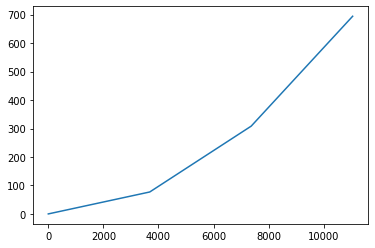

In [137]:
plt.plot(x0, z0)
plt.show()

In [138]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [139]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)

In [140]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])

    
    
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]

#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 = d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
############################################################    
    ddx,ddy, ddz = np.linalg.solve(Ws*Re_b(Ret),Z).T 
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
#     tmp=phi(ddx_phi,ddy_phi, ddz_phi, Ret)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
############################################################    
#     ans_x=[]
#     ans_y=[]
#     ans_z=[]
#     RRRR=Re_b(Ret)
#     for i in range(len(RRRR)):
#         a,b,c=1/Ws*np.linalg.lstsq(RRRR[i],Z[i], rcond=None)[0]
#         ans_x.append(a)
#         ans_y.append(b)
#         ans_z.append(c)
    
#     ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)    
    
   
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))


#############
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################




#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    
    

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans
    

In [141]:
q0

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [142]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [143]:
root

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,    77.06804645,   308.4070593 ,   694.42189511,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ])

In [144]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [145]:
x0

[0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162]

In [146]:
x0_

array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446])

In [147]:
z0

[0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863]

In [148]:
z0_

array([  0.        ,  77.06804645, 308.4070593 , 694.42189511])

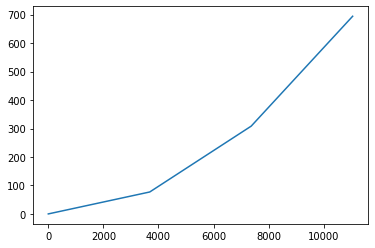

In [149]:
plt.plot(x0_, z0_)
plt.show()

In [150]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,1])
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0,0,0,1])

In [151]:
# q0[10*node_N]=q0[8*node_N]=0

In [152]:
q0

array([0.00000000e+00, 3.68422828e+03, 7.36845656e+03, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.70680464e+01, 3.08407059e+02, 6.94421895e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

### Dynamics

In [153]:
# def grayscott1d(Q,p,t):
def grayscott1d(t, Q):
    print(t)
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
# #     x[-1]=x0[-1]+10*np.sin(t)
#     x[-1]=x0_[-1]+100*np.sin(t)
# #     y[-1]+=5*np.cos(t)
# #     z[-1]=z0[-1]+2.5*np.sin(t)
#     z[-1]=z0_[-1]+2.5*np.sin(t)

#     x[0]=0
#     y[0]=0
#     z[0]=0

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    dη=[dx[-1],dy[-1],dz[-1],dφ[-1],dθ[-1],dψ[-1]]
    
    left=V.eq_left(η,dη)

    # PD controller after 30 sec
#     if t<30:
#         ddη=np.linalg.lstsq(V.M, -left + tau(η, dη, wave_coef, Fx_0/η[0], 0, t), rcond=None)[0]
#     else:

    hack =1
    hack3=1e-6
    ddη=np.linalg.lstsq(V.M.astype(np.float32)*hack, left.astype(np.float32) 
                        - hack3*tau(η,dη, wave_coef, kp, kd, t).astype(np.float32)
                        , rcond=None)[0]
#     print('ddη', ddη)
 
    tau_force = V.tau(η,dη,ddη).astype(np.float32)
#     tau_force = hack*tau(η,dη, wave_coef, kp, kd, t) # simple motion 
#     print(tau_force)
#     C=ne(x,y,z,Ret)
#     a,b,c=C[:,0],C[:,1],C[:,2]
#     Z0=tau_force[:3]
#     Z0=tau_force[:3]

    Z0=np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret,Z0)
#     print(x,z)
   
#     Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T
    
    Z= (Z1 + Z2 
        + Z0
       )

############################################################    
#     ddx,ddy, ddz = 1/Ws*np.linalg.solve(Re_b(Ret),Z).T 
############################################################    
    ans_x=[]
    ans_y=[]
    ans_z=[]
    RRRR=Re_b(Ret)
    hack2=1e-1
    for i in range(len(RRRR)):
        a,b,c=np.linalg.lstsq(Ws*RRRR[i]
#                               +hack2*np.identity(3)
                              , Z[i], rcond=None)[0]
        ans_x.append(a)
        ans_y.append(b)
        ans_z.append(c)
    
    ddx,ddy, ddz = np.array(ans_x),np.array(ans_y),np.array(ans_z)
#     print(ddx,ddy, ddz)
    
#     tmp=np.linalg.solve(Ret,np.vstack([ddx_phi, ddy_phi, ddz_phi]).T)
#     ddx, ddy, ddz = tmp[:,0],tmp[:,1],tmp[:,2]
    
    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
    
#     print(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T))
#     print(np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
#                            np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))

#     C3= d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T
    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None))
#     print(d_s(phi,x,y,z,Ret).T)
#     print(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)
#     print(np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)).shape)

#     C0=np.einsum('ijk,kp->ijp',
#                  np.linalg.inv(Π(φ,θ,ψ)), tau_force[3:].reshape(3,1)
#                 ) 
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
#     print(C1.shape,C2.shape,C3.shape,C4.shape,C5.shape)
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
#     A=np.einsum('ijk,ikr->ijr', Re_b(Ret), np.einsum('ijk,ikr->ijr',A2,A3))

############################################
#     ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i]
                              +hack2*np.identity(3)
                              ,B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
    ddφ*=np.exp(-t)
    ddθ*=np.exp(-t)
    ddψ*=np.exp(-t)
#     ddx[-1],ddy[-1],ddz[-1],ddφ[-1],ddθ[-1],ddψ[-1]=ddη
#     print(ddφ,ddθ,ddψ)

    ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     A1111=np.concatenate([dx, ddx, 
#                           np.zeros(node_N), np.zeros(node_N),
#                           dz, ddz,
#                           np.zeros(node_N),  np.zeros(node_N),
#                           np.zeros(node_N), np.zeros(node_N),
#                           np.zeros(node_N),  np.zeros(node_N),
#                           ], axis=0)

        

#     print(A1111)
    return A1111

In [154]:
# ode15s = scipy.integrate.ode(grayscott1d)
# # ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# ode15s.set_integrator('vode',  order=15, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [155]:
# us=ode15s.integrate(10)

In [156]:
tspan = (0., 5)
# tspan = (0., 10)

In [157]:
startTime1 = datetime.now()
# prob = de.ODEProblem(grayscott1d, q0, tspan)
# us = de.solve(prob)
us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
             method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
# us=ode15s.integrate(10)
print(datetime.now() - startTime1)

0.0
3.1936606118404395e-15
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.4819577491496617e-13
1.4819577491496617e-13
2.9639154982993234e-13
2.9639154982993234e-13
1.7783492989795941e-12
1.7783492989795941e-12
3.2603070481292557e-12
3.2603070481292557e-12
1.1605260233582803e-11
1.1605260233582803e-11
1.995021341903635e-11
1.995021341903635e-11
2.8295166604489898e-11
2.8295166604489898e-11
5.897608622193374e-11
5.897608622193374e-11
8.965700583937757e-11
8.965700583937757e-11
1.203379254568214e-10
1.203379254568214e-10
2.0549098347774458e-10
2.0549098347774458e-10
2.906440414986678e-10
2.906440414986678e-10
3.7579709951959096e-10
3.7579709951959096e-10
4.6095015754051414e-10
4.6095015754051414e-10
6.364258214818582e-10
6.364258214818582e-10
8.119014854232023e-10
8.119014854232023e-10
9.873771493645465e-10
9.873771493645465e-10

6.500398159330657e-09
6.500398159330657e-09
6.620779658763107e-09
6.620779658763107e-09
6.741161158195557e-09
6.741161158195557e-09
6.669411664553631e-09
6.669411664553631e-09
6.647443789152602e-09
6.647443789152602e-09
6.638618303270335e-09
6.638618303270335e-09
6.634414009741773e-09
6.634414009741773e-09
6.6480483607204385e-09
6.6480483607204385e-09
6.661682711699104e-09
6.661682711699104e-09
6.675925953193012e-09
6.675925953193012e-09
6.6901691946869205e-09
6.6901691946869205e-09
6.704412436180829e-09
6.704412436180829e-09
6.742681750387402e-09
6.742681750387402e-09
6.780951064593975e-09
6.780951064593975e-09
6.8192203788005476e-09
6.8192203788005476e-09
6.9843150252089944e-09
6.9843150252089944e-09
6.884394886953498e-09
6.884394886953498e-09
6.9495693951064485e-09
6.9495693951064485e-09
6.918069424114125e-09
6.918069424114125e-09
6.906008660076268e-09
6.906008660076268e-09
6.9276224331990375e-09
6.9276224331990375e-09
6.921886452267658e-09
6.921886452267658e-09
6.937764244459048e-0

9.205614065576914e-09
9.202999840927929e-09
9.202999840927929e-09
9.201779689252106e-09
9.201779689252106e-09
9.201133659300668e-09
9.201133659300668e-09
9.200759438215984e-09
9.200759438215984e-09
9.202318155009571e-09
9.202318155009571e-09
9.203876871803158e-09
9.203876871803158e-09
9.205435588596745e-09
9.205435588596745e-09
9.207374161843286e-09
9.207374161843286e-09
9.209312735089827e-09
9.209312735089827e-09
9.211251308336369e-09
9.211251308336369e-09
9.21318988158291e-09
9.21318988158291e-09
9.220057201925739e-09
9.220057201925739e-09
9.226924522268567e-09
9.226924522268567e-09
9.233791842611395e-09
9.233791842611395e-09
9.259150083768508e-09
9.259150083768508e-09
9.284508324925621e-09
9.284508324925621e-09
9.277354179022302e-09
9.277354179022302e-09
9.295558274276097e-09
9.295558274276097e-09
9.291805600006929e-09
9.291805600006929e-09
9.306257020991556e-09
9.306257020991556e-09
9.320708441976183e-09
9.320708441976183e-09
9.343220798874329e-09
9.343220798874329e-09
9.3657331557

1.0816018377044087e-08
1.081300413989248e-08
1.081300413989248e-08
1.0825263537324724e-08
1.0825263537324724e-08
1.0837522934756969e-08
1.0837522934756969e-08
1.0856840500697195e-08
1.0856840500697195e-08
1.0876158066637422e-08
1.0876158066637422e-08
1.0895475632577649e-08
1.0895475632577649e-08
1.0914793198517875e-08
1.0914793198517875e-08
1.0910866203871802e-08
1.0910866203871802e-08
1.0926256775165956e-08
1.0926256775165956e-08
1.094164734646011e-08
1.094164734646011e-08
1.0957037917754263e-08
1.0957037917754263e-08
1.0994921487128572e-08
1.0994921487128572e-08
1.103280505650288e-08
1.103280505650288e-08
1.107068862587719e-08
1.107068862587719e-08
1.105338987486554e-08
1.105338987486554e-08
1.1046511946833306e-08
1.1046511946833306e-08
1.1060218837163732e-08
1.1060218837163732e-08
1.1057159266799475e-08
1.1057159266799475e-08
1.1067806586765644e-08
1.1067806586765644e-08
1.1078453906731813e-08
1.1078453906731813e-08
1.1104799055268238e-08
1.1104799055268238e-08
1.1098622403988079e-0

1.3541375437941115e-08
1.3534485081362347e-08
1.3534485081362347e-08
1.353104390111109e-08
1.353104390111109e-08
1.3545250879206041e-08
1.3545250879206041e-08
1.3559457857300993e-08
1.3559457857300993e-08
1.3581790719561058e-08
1.3581790719561058e-08
1.3570162388744779e-08
1.3570162388744779e-08
1.3565633794065336e-08
1.3565633794065336e-08
1.357180973082968e-08
1.357180973082968e-08
1.3569742312642335e-08
1.3569742312642335e-08
1.3568660996652273e-08
1.3568660996652273e-08
1.3568041602070012e-08
1.3568041602070012e-08
1.3570449410074689e-08
1.3570449410074689e-08
1.3569983953134597e-08
1.3569983953134597e-08
1.3571926304199181e-08
1.3571926304199181e-08
1.3573868655263765e-08
1.3573868655263765e-08
1.357581100632835e-08
1.357581100632835e-08
1.3580592061180593e-08
1.3580592061180593e-08
1.3585373116032835e-08
1.3585373116032835e-08
1.3590154170885078e-08
1.3590154170885078e-08
1.3599186203619363e-08
1.3599186203619363e-08
1.3608218236353648e-08
1.3608218236353648e-08
1.361725026908793

1.4601760957339788e-08
1.4601760957339788e-08
1.4610694733999938e-08
1.4610694733999938e-08
1.4626460092768578e-08
1.4626460092768578e-08
1.4642225451537217e-08
1.4642225451537217e-08
1.4633544336626347e-08
1.4633544336626347e-08
1.4640628580484117e-08
1.4640628580484117e-08
1.4637585221998635e-08
1.4637585221998635e-08
1.4636317655502548e-08
1.4636317655502548e-08
1.463909097437875e-08
1.463909097437875e-08
1.463845342583442e-08
1.463845342583442e-08
1.464058919616629e-08
1.464058919616629e-08
1.4642724966498162e-08
1.4642724966498162e-08
1.4646832842253094e-08
1.4646832842253094e-08
1.4650940718008026e-08
1.4650940718008026e-08
1.466540195620952e-08
1.466540195620952e-08
1.4679863194411014e-08
1.4679863194411014e-08
1.4694324432612509e-08
1.4694324432612509e-08
1.471952132970353e-08
1.471952132970353e-08
1.474471822679455e-08
1.474471822679455e-08
1.473288194200578e-08
1.473288194200578e-08
1.4727931603930365e-08
1.4727931603930365e-08
1.472548060759519e-08
1.472548060759519e-08
1.47

1.553786756890455e-08
1.5532720869369525e-08
1.5532720869369525e-08
1.554190642395725e-08
1.554190642395725e-08
1.5539133587364843e-08
1.5539133587364843e-08
1.553762293484241e-08
1.553762293484241e-08
1.5542525000315295e-08
1.5542525000315295e-08
1.5541502082150153e-08
1.5541502082150153e-08
1.5545381229457897e-08
1.5545381229457897e-08
1.554926037676564e-08
1.554926037676564e-08
1.5553139524073385e-08
1.5553139524073385e-08
1.5559782959857115e-08
1.5559782959857115e-08
1.5566426395640846e-08
1.5566426395640846e-08
1.5573069831424577e-08
1.5573069831424577e-08
1.558720456687213e-08
1.558720456687213e-08
1.560133930231968e-08
1.560133930231968e-08
1.5593875452977627e-08
1.5593875452977627e-08
1.5600546339083124e-08
1.5600546339083124e-08
1.559780759022478e-08
1.559780759022478e-08
1.5596638464107832e-08
1.5596638464107832e-08
1.5596058196887195e-08
1.5596058196887195e-08
1.5598240940796764e-08
1.5598240940796764e-08
1.5600423684706332e-08
1.5600423684706332e-08
1.5605228743352498e-08
1

1.6229277734671087e-08
1.6228896476336667e-08
1.6228896476336667e-08
1.6230056885300392e-08
1.6230056885300392e-08
1.6231217294264118e-08
1.6231217294264118e-08
1.6232421316400973e-08
1.6232421316400973e-08
1.6233625338537828e-08
1.6233625338537828e-08
1.6234829360674684e-08
1.6234829360674684e-08
1.6238389060694723e-08
1.6238389060694723e-08
1.6241948760714762e-08
1.6241948760714762e-08
1.6247521522713714e-08
1.6247521522713714e-08
1.6253094284712665e-08
1.6253094284712665e-08
1.6258667046711617e-08
1.6258667046711617e-08
1.6272310963258346e-08
1.6272310963258346e-08
1.6285954879805075e-08
1.6285954879805075e-08
1.627729594061896e-08
1.627729594061896e-08
1.6282280917979573e-08
1.6282280917979573e-08
1.627971208274708e-08
1.627971208274708e-08
1.627878634076012e-08
1.627878634076012e-08
1.6278375093960275e-08
1.6278375093960275e-08
1.627945424730159e-08
1.627945424730159e-08
1.6279234016065642e-08
1.6279234016065642e-08
1.628009293817101e-08
1.628009293817101e-08
1.6280951860276376e-0

1.6661943275106364e-08
1.6661943275106364e-08
1.6662487206544316e-08
1.6662487206544316e-08
1.6663031137982268e-08
1.6663031137982268e-08
1.6664302973945998e-08
1.6664302973945998e-08
1.6665574809909728e-08
1.6665574809909728e-08
1.666684664587346e-08
1.666684664587346e-08
1.6670089976303048e-08
1.6670089976303048e-08
1.6673333306732637e-08
1.6673333306732637e-08
1.6676576637162226e-08
1.6676576637162226e-08
1.6683873769280383e-08
1.6683873769280383e-08
1.669117090139854e-08
1.669117090139854e-08
1.66984680335167e-08
1.66984680335167e-08
1.6708311163140706e-08
1.6708311163140706e-08
1.6700610833166915e-08
1.6700610833166915e-08
1.6702753632817132e-08
1.6702753632817132e-08
1.670489643246735e-08
1.670489643246735e-08
1.6712039826529906e-08
1.6712039826529906e-08
1.670721471410545e-08
1.670721471410545e-08
1.6709532995743552e-08
1.6709532995743552e-08
1.6708376190712106e-08
1.6708376190712106e-08
1.6707947759904233e-08
1.6707947759904233e-08
1.670775433631877e-08
1.670775433631877e-08
1.

1.7177076342447255e-08
1.7179576584130695e-08
1.7179576584130695e-08
1.7182076825814136e-08
1.7182076825814136e-08
1.7189367083787775e-08
1.7189367083787775e-08
1.7196657341761414e-08
1.7196657341761414e-08
1.7203947599735054e-08
1.7203947599735054e-08
1.7216490398108603e-08
1.7216490398108603e-08
1.7229033196482152e-08
1.7229033196482152e-08
1.7223241606252035e-08
1.7223241606252035e-08
1.7220778928021514e-08
1.7220778928021514e-08
1.7225067457934425e-08
1.7225067457934425e-08
1.7223765728990357e-08
1.7223765728990357e-08
1.7223060819005756e-08
1.7223060819005756e-08
1.7225342709989998e-08
1.7225342709989998e-08
1.7224860439844253e-08
1.7224860439844253e-08
1.722666006068275e-08
1.722666006068275e-08
1.7228459681521248e-08
1.7228459681521248e-08
1.7230259302359745e-08
1.7230259302359745e-08
1.723475733963505e-08
1.723475733963505e-08
1.7239255376910353e-08
1.7239255376910353e-08
1.7243753414185657e-08
1.7243753414185657e-08
1.7253673029130663e-08
1.7253673029130663e-08
1.7263592644075

1.7858247647966486e-08
1.7858247647966486e-08
1.7865784028000136e-08
1.7865784028000136e-08
1.7875846787815016e-08
1.7875846787815016e-08
1.7885909547629895e-08
1.7885909547629895e-08
1.7895972307444774e-08
1.7895972307444774e-08
1.789378456065129e-08
1.789378456065129e-08
1.7901659573672682e-08
1.7901659573672682e-08
1.7909534586694075e-08
1.7909534586694075e-08
1.791740959971547e-08
1.791740959971547e-08
1.7929473604761315e-08
1.7929473604761315e-08
1.794153760980716e-08
1.794153760980716e-08
1.7937042912109652e-08
1.7937042912109652e-08
1.793502435896907e-08
1.793502435896907e-08
1.794057511317683e-08
1.794057511317683e-08
1.7946125867384586e-08
1.7946125867384586e-08
1.795740081462139e-08
1.795740081462139e-08
1.7954017969086817e-08
1.7954017969086817e-08
1.7961910070789048e-08
1.7961910070789048e-08
1.7972326862170655e-08
1.7972326862170655e-08
1.7982743653552262e-08
1.7982743653552262e-08
1.799316044493387e-08
1.799316044493387e-08
1.7989752179008384e-08
1.7989752179008384e-08
1.

1.9751952976056247e-08
1.9751952976056247e-08
1.974751134874072e-08
1.974751134874072e-08
1.975847022059769e-08
1.975847022059769e-08
1.975622752837037e-08
1.975622752837037e-08
1.9764943708000017e-08
1.9764943708000017e-08
1.977621420541199e-08
1.977621420541199e-08
1.9787484702823966e-08
1.9787484702823966e-08
1.980240285734831e-08
1.980240285734831e-08
1.9817321011872653e-08
1.9817321011872653e-08
1.9832239166396997e-08
1.9832239166396997e-08
1.9858085029352612e-08
1.9858085029352612e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-08
1.9848680693089062e-0

2.0570819911545284e-08
2.0582093747161624e-08
2.0582093747161624e-08
2.0599753510217423e-08
2.0599753510217423e-08
2.061741327327322e-08
2.061741327327322e-08
2.0633893618429575e-08
2.0633893618429575e-08
2.0629479505318842e-08
2.0629479505318842e-08
2.0641545737364463e-08
2.0641545737364463e-08
2.0652824489836688e-08
2.0652824489836688e-08
2.0664103242308914e-08
2.0664103242308914e-08
2.0678295783324975e-08
2.0678295783324975e-08
2.0692488324341036e-08
2.0692488324341036e-08
2.0705643948140735e-08
2.0705643948140735e-08
2.0718799571940433e-08
2.0718799571940433e-08
2.073195519574013e-08
2.073195519574013e-08
2.075572630669809e-08
2.075572630669809e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.0779497417656048e-08
2.077949741765604

2.1915251054070724e-08
2.1911223408714e-08
2.1911223408714e-08
2.1924053032555475e-08
2.1924053032555475e-08
2.19355322457544e-08
2.19355322457544e-08
2.1947011458953323e-08
2.1947011458953323e-08
2.1958490672152246e-08
2.1958490672152246e-08
2.197162016522985e-08
2.197162016522985e-08
2.1984749658307456e-08
2.1984749658307456e-08
2.1999609065576202e-08
2.1999609065576202e-08
2.2014468472844947e-08
2.2014468472844947e-08
2.2029327880113693e-08
2.2029327880113693e-08
2.204510753669168e-08
2.204510753669168e-08
2.2060887193269667e-08
2.2060887193269667e-08
2.2076666849847653e-08
2.2076666849847653e-08
2.209290650840277e-08
2.209290650840277e-08
2.2109146166957883e-08
2.2109146166957883e-08
2.2125385825512998e-08
2.2125385825512998e-08
2.2145752100066417e-08
2.2145752100066417e-08
2.2166118374619835e-08
2.2166118374619835e-08
2.2187511493587803e-08
2.2187511493587803e-08
2.2187511493587803e-08
2.2187511493587803e-08
2.2187511493587803e-08
2.2187511493587803e-08
2.2187511493587803e-08
2.21

2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.3801778274775307e-08
2.378668935419095e-08
2.378668935419095e-08
2.3782898705342804e-08
2.3782898705342804e-08
2.3794196977079015e-08
2.3794196977079015e-08
2.3790667029953412e-08
2.3790667029953412e-08
2.379843535456402e-08
2.379843535456402e-08
2.3810305397859932e-08
2.3810305397859932e-08
2.3822175441155845e-08
2.3822175441155845e-08
2.3835154472813028e-08
2.3835154472813028e-08
2.384813350447021e-08
2.384813350447021e-08
2.3863351653544962e-08
2.3863351653544962e-08
2.3878569802619714e-08
2.3878569802619714e-08
2.387481812959401e-08
2.387481812959401e-08
2.388628460564306e-08
2.388628460564306e-08
2.3905495069248408e-08
2.3905495069248408e-08
2.390157766465889e-08
2.390157766465889e-08
2.391687072367472e-08
2.391687072367472e-08
2.3932163782690552e-08
2.

2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.6015022233048697e-08
2.601502223

2.6318879871060294e-08
2.6318879871060294e-08
2.63220920697742e-08
2.63220920697742e-08
2.6325304268488103e-08
2.6325304268488103e-08
2.6330156689552468e-08
2.6330156689552468e-08
2.6335009110616832e-08
2.6335009110616832e-08
2.6339861531681196e-08
2.6339861531681196e-08
2.634471395274556e-08
2.634471395274556e-08
2.6350911820640738e-08
2.6350911820640738e-08
2.6357109688535915e-08
2.6357109688535915e-08
2.636330755643109e-08
2.636330755643109e-08
2.636950542432627e-08
2.636950542432627e-08
2.6376811690269934e-08
2.6376811690269934e-08
2.63841179562136e-08
2.63841179562136e-08
2.6391424222157264e-08
2.6391424222157264e-08
2.6402072911007768e-08
2.6402072911007768e-08
2.641272159985827e-08
2.641272159985827e-08
2.642686277883632e-08
2.642686277883632e-08
2.644100395781437e-08
2.644100395781437e-08
2.645514513679242e-08
2.645514513679242e-08
2.6471331550999117e-08
2.6471331550999117e-08
2.6468052153043176e-08
2.6468052153043176e-08
2.646535267337055e-08
2.646535267337055e-08
2.6475560209

2.7291410399010227e-08
2.7305870009104702e-08
2.7305870009104702e-08
2.7320329619199178e-08
2.7320329619199178e-08
2.735591808951241e-08
2.735591808951241e-08
2.7391506559825644e-08
2.7391506559825644e-08
2.7380806754563634e-08
2.7380806754563634e-08
2.7405695419614857e-08
2.7405695419614857e-08
2.7399528309638756e-08
2.7399528309638756e-08
2.7418249864713878e-08
2.7418249864713878e-08
2.7436971419789e-08
2.7436971419789e-08
2.7432775593466815e-08
2.7432775593466815e-08
2.744730132221975e-08
2.744730132221975e-08
2.7461827050972688e-08
2.7461827050972688e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-08
2.7480001193142834e-0

2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.7683239013291764e-08
2.768323901

2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8092036262158602e-08
2.8084857363983207e-08
2.8084857363983207e-08
2.80920362621586e-08
2.80920362621586e-08
2.809921516033399e-08
2.809921516033399e-08
2.8108508340148836e-08
2.8108508340148836e-08
2.8105879822191964e-08
2.8105879822191964e-08
2.8112544484049937e-08
2.8112544484049937e-08
2.8123217836640478e-08
2.8123217836640478e-08
2.812084894051740

2.8600898449805646e-08
2.8600898449805646e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587165637963e-08
2.860587

2.9230139940307033e-08
2.9230139940307033e-08
2.9241729276171424e-08
2.9241729276171424e-08
2.9253318612035815e-08
2.9253318612035815e-08
2.9275617565556713e-08
2.9275617565556713e-08
2.9269179302601494e-08
2.9269179302601494e-08
2.9265364853745926e-08
2.9265364853745926e-08
2.9277411095456037e-08
2.9277411095456037e-08
2.9289457337166148e-08
2.9289457337166148e-08
2.930086147154304e-08
2.930086147154304e-08
2.9312265605919933e-08
2.9312265605919933e-08
2.9323669740296825e-08
2.9323669740296825e-08
2.934162791000005e-08
2.934162791000005e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.933365250442516e-08
2.9333652504

2.9701749445554014e-08
2.97185899186167e-08
2.97185899186167e-08
2.97145145810483e-08
2.97145145810483e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e-08
2.9727279716542583e

3.0837534794701946e-08
3.0837534794701946e-08
3.084717661734523e-08
3.084717661734523e-08
3.085967543493164e-08
3.085967543493164e-08
3.085664223176203e-08
3.085664223176203e-08
3.086610784617884e-08
3.086610784617884e-08
3.086325345569809e-08
3.086325345569809e-08
3.0869864679634144e-08
3.0869864679634144e-08
3.088065780794348e-08
3.088065780794348e-08
3.0875882012385356e-08
3.0875882012385356e-08
3.088189934513657e-08
3.088189934513657e-08
3.0888005315132225e-08
3.0888005315132225e-08
3.0894111285127884e-08
3.0894111285127884e-08
3.0900654955447045e-08
3.0900654955447045e-08
3.090719862576621e-08
3.090719862576621e-08
3.0915227703343475e-08
3.0915227703343475e-08
3.092325678092074e-08
3.092325678092074e-08
3.0931390508070736e-08
3.0931390508070736e-08
3.093952423522073e-08
3.093952423522073e-08
3.0947657962370724e-08
3.0947657962370724e-08
3.096430430045953e-08
3.096430430045953e-08
3.0980950638548336e-08
3.0980950638548336e-08
3.09977381328415e-08
3.09977381328415e-08
3.101452562713

3.155343457796714e-08
3.155343457796714e-08
3.1557214571824867e-08
3.1557214571824867e-08
3.1560994565682595e-08
3.1560994565682595e-08
3.156477455954032e-08
3.156477455954032e-08
3.1573160863355185e-08
3.1573160863355185e-08
3.158154716717005e-08
3.158154716717005e-08
3.158993347098491e-08
3.158993347098491e-08
3.160675687847985e-08
3.160675687847985e-08
3.1623580285974785e-08
3.1623580285974785e-08
3.164040369346972e-08
3.164040369346972e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.167264657279706e-08
3.

3.196267582998708e-08
3.196267582998708e-08
3.197277009092095e-08
3.197277009092095e-08
3.198286435185482e-08
3.198286435185482e-08
3.198286435185482e-08
3.1990495608361634e-08
3.1990495608361634e-08
3.199812686486845e-08
3.199812686486845e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-08
3.2013955678719136e-

3.228139820313462e-08
3.228139820313462e-08
3.227736121949658e-08
3.227736121949658e-08
3.228843230195447e-08
3.228843230195447e-08
3.229950338441236e-08
3.229950338441236e-08
3.231141269688464e-08
3.231141269688464e-08
3.2309027916703545e-08
3.2309027916703545e-08
3.231855244899473e-08
3.231855244899473e-08
3.232807698128592e-08
3.232807698128592e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557514899781e-08
3.235557

3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.241518292607904e-08
3.24151829

3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272358135540279e-08
3.272358135540279e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.272864379636963e-08
3.27286437

3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.303763176480167e-08
3.30376317

3.321450913251222e-08
3.321806929535346e-08
3.321806929535346e-08
3.321667634578009e-08
3.321667634578009e-08
3.321626419906236e-08
3.321626419906236e-08
3.32180192656125e-08
3.32180192656125e-08
3.321977433216264e-08
3.321977433216264e-08
3.321930937584198e-08
3.321930937584198e-08
3.322059948607146e-08
3.322059948607146e-08
3.3221889596300943e-08
3.3221889596300943e-08
3.3221625919296856e-08
3.3221625919296856e-08
3.322265235252225e-08
3.322265235252225e-08
3.322367878574764e-08
3.322367878574764e-08
3.322345959393664e-08
3.322345959393664e-08
3.322426683535103e-08
3.322426683535103e-08
3.32240694609884e-08
3.32240694609884e-08
3.3224679328040166e-08
3.3224679328040166e-08
3.322528919509193e-08
3.322528919509193e-08
3.322589906214369e-08
3.322589906214369e-08
3.322652526723043e-08
3.322652526723043e-08
3.3227151472317174e-08
3.3227151472317174e-08
3.3227777677403916e-08
3.3227777677403916e-08
3.322761279043938e-08
3.322761279043938e-08
3.322807410856159e-08
3.322807410856159e-08
3.32

3.337403050535874e-08
3.337403050535874e-08
3.337403050535874e-08
3.337403050535874e-08
3.337403050535874e-08
3.337403050535874e-08
3.337234589842999e-08
3.337234589842999e-08
3.337403050535874e-08
3.337403050535874e-08
3.3376615141213655e-08
3.3376615141213655e-08
3.337919977706857e-08
3.337919977706857e-08
3.338267250146047e-08
3.338267250146047e-08
3.3386145225852364e-08
3.3386145225852364e-08
3.3392159117498055e-08
3.3392159117498055e-08
3.3398173009143745e-08
3.3398173009143745e-08
3.340751076889175e-08
3.340751076889175e-08
3.34042049092359e-08
3.34042049092359e-08
3.341023680932806e-08
3.341023680932806e-08
3.340811915751191e-08
3.340811915751191e-08
3.341203340578792e-08
3.341203340578792e-08
3.341982039387072e-08
3.341982039387072e-08
3.342760738195352e-08
3.342760738195352e-08
3.343840178335478e-08
3.343840178335478e-08
3.3449196184756044e-08
3.3449196184756044e-08
3.3449196184756044e-08
3.3449196184756044e-08
3.3449196184756044e-08
3.3449196184756044e-08
3.3449196184756044e-

3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.352161224689816e-08
3.3514427026881244e-08
3.3514427026881244e-08
3.352161224689816e-08
3.352161224689816e-08
3.352882321708637e-08
3.352882321708637e-08
3.353603418727457e-08
3.353603418727457e-08
3.3543245157462776e-08
3.3543245157462776e-08
3.35517157124692e-08
3.35517157124692e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018626747562e-08
3.356018

3.366569376184171e-08
3.366569376184171e-08
3.366569376184171e-08
3.366569376184171e-08
3.366150946068806e-08
3.366150946068806e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.3665693761841705e-08
3.366569376184170

3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.3810623281268784e-08
3.381062328

3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38430496367919e-08
3.38409055417638e-08
3.38409055417638e-08
3.3843049636791905e-08
3.3843049636791905e-08
3.384769372344658e-08
3.384769372344658e-08
3.385233781010126e-08
3.385233781010126e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.38575984900444e-08
3.385

3.411554536656542e-08
3.411554536656542e-08
3.412347207487333e-08
3.412347207487333e-08
3.412347207487333e-08
3.412023764510778e-08
3.412023764510778e-08
3.4119323176191935e-08
3.4119323176191935e-08
3.4119323176191935e-08
3.412310098581845e-08
3.412310098581845e-08
3.412310098581845e-08
3.4130223461386096e-08
3.4130223461386096e-08
3.4128814879752984e-08
3.4128814879752984e-08
3.412717097658671e-08
3.412717097658671e-08
3.412602163376331e-08
3.412602163376331e-08
3.412894228170818e-08
3.412894228170818e-08
3.413404744070532e-08
3.413404744070532e-08
3.413915259970246e-08
3.413915259970246e-08
3.413783884690255e-08
3.413783884690255e-08
3.414163025309978e-08
3.414163025309978e-08
3.414700719692817e-08
3.414700719692817e-08
3.4152384140756564e-08
3.4152384140756564e-08
3.415780379285182e-08
3.415780379285182e-08
3.416322344494707e-08
3.416322344494707e-08
3.416322344494707e-08
3.416322344494707e-08
3.416322344494707e-08
3.416322344494707e-08
3.416322344494707e-08
3.416322344494707e-08
3

3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.429239817895955e-08
3.42893436828507e-08
3.42893436828507e-08
3.429239817895955e-08
3.429239817895955e-08
3.429869165529029e-08
3.429869165529029e-08
3.430498513162103e-08
3.430498513162103e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.431397147677099e-08
3.4313971476

3.43515973200398e-08
3.434915849658101e-08
3.434915849658101e-08
3.43515973200398e-08
3.43515973200398e-08
3.4356210852783064e-08
3.4356210852783064e-08
3.436082438552633e-08
3.436082438552633e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826942059e-08
3.436954826

3.446831626362504e-08
3.447561010434999e-08
3.447561010434999e-08
3.44853451918505e-08
3.44853451918505e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014e-08
3.4495080279351014

3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.457435941439623e-08
3.45743594

3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.465446035097847e-08
3.4652044223465105e-08
3.4652044223465105e-08
3.465446035097848e-08
3.465446035097848e-08
3.465970078838046e-08
3.465970078838046e-08
3.466494122578244e-08
3.466494122578244e-08
3.4672567700966575e-08
3.4672567700966575e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.468019417615071e-08
3.4680

3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.47158456655269e-08
3.4711083558591516e-08
3.471108355

3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480882349072993e-08
3.480117136778965e-08
3.480117136778965e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.480882349072994e-08
3.48088234

3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.4893054181094616e-08
3.489305418

3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.498615695234314e-08
3.498615695234314e-08
3.4989374881499165e-08
3.4989374881499165e-08
3.49984627739

3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.506763066246676e-08
3.5060189085590345e-08
3.5060189085590345e-08
3.506763066246675e-08
3.506763066246675e-08
3.507955539409268e-08
3.507955539409268e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148012571861e-08
3.509148

3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.513660686787507e-08
3.5133812112769277e-08
3.5133812112769277e-08
3.513660686787507e-08
3.513660686787507e-08
3.5147819983673315e-08
3.5147819983673315e-08
3.515903309947156e-08
3.515903309947156e-08
3.517921981843543e-08
3.5179

3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.5266584224935575e-08
3.5266584224935575e-08
3.5269870806038805e-08
3.5269870806038805e-08
3.527779951622446e-08
3.527779951622446e-08
3.5285728226410115e-08
3.5285728226410115e-08
3.529365693659577e-08
3.529365693659577e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504994e-08
3.5306408778504

3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.534233860100064e-08
3.5337194892963835e-08
3.5337194892963835e-08
3.533462303894543e-08
3.533462

3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.541172988229166e-08
3.540956573486172e-08
3.540956573486172e-08
3.541172988229167e-08
3.541172988229167e-08
3.541784302213042e-08
3.541784302213042e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956161969176e-08
3.5423956

3.5514482504609354e-08
3.5514482504609354e-08
3.5514482504609354e-08
3.5514482504609354e-08
3.5503171583142395e-08
3.5503171583142395e-08
3.5497516122408916e-08
3.5497516122408916e-08
3.549468839204218e-08
3.549468839204218e-08
3.549751612240892e-08
3.549751612240892e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.550973734491525e-08
3.

3.566029558481491e-08
3.566029558481491e-08
3.565681665805763e-08
3.565681665805763e-08
3.565507719467898e-08
3.565507719467898e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.565681665805762e-08
3.56568166

3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570433769036337e-08
3.570084719446133e-08
3.570084719446133e-08
3.569910194651031e-08
3.569910194651031e-08
3.569822932253481e-08
3.569822932253481e-08
3.569910194651032e-08
3.569910194651032e-08
3.569910194651032e-08
3.569910194651032e-08
3.569910194651032e-08
3.569910194651032e-08
3.569910194651032e-08
3.56991019

3.5724077066253896e-08
3.5725005728209156e-08
3.5725005728209156e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.5728887189005247e-08
3.572888718

3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.580493652442169e-08
3.579604680676482e-08
3.579604680676482e-08
3.579160194793639e-08
3.579160194793639e-08
3.579604680676482e-08
3.579604680676482e-08
3.5803766221677766e-08
3.5803766221677766e-08
3.581148563659071e-08
3.581148563659071e-08
3.582471331790466e-08
3.582471331790466e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-08
3.5837940999218616e-

3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.588956153998429e-08
3.58895615

3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593525233829367e-08
3.593179306319574e-08
3.593179306319574e-08
3.593525233829367e-08
3.593525233829367e-08
3.594360097060417e-08
3.594360097060417e-08
3.595194960291467e-08
3.595194960291467e-08
3.596029823522517e-08
3.596029823522517e-08
3.5974982751224664e-08
3.5974982751224664e-08
3.598966726722416e-08
3.598966726722416e-08
3.600435178322366e-08
3.600435178322366e-08
3.6019036299223155e-08
3.6019036299223155e-08
3.603668983469603e-08
3.603668983469603e-08
3.60543433701689e-08
3.60543433701689e-08
3.6071996905641776e-08
3.6071996905641776e-08
3.6089

3.7059006221671033e-08
3.705193559708873e-08
3.705193559708873e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.705900622167103e-08
3.7059006

3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.7146769421701544e-08
3.7146769421701544e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020135040798e-08
3.715020

3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.727857226251606e-08
3.7272421361638344e-08
3.7272421361638344e-08
3.727857226251605e-08
3.727857226251605e-08
3.7299250357769084e-08
3.7299250357769084e-08
3.7299250357769084e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729310978471641e-08
3.729

3.799672469164797e-08
3.799672469164797e-08
3.799672469164797e-08
3.79824818127236e-08
3.79824818127236e-08
3.797536037326141e-08
3.797536037326141e-08
3.797536037326141e-08
3.79824818127236e-08
3.79824818127236e-08
3.7990420821248205e-08
3.7990420821248205e-08
3.799835982977281e-08
3.799835982977281e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.8011479386041505e-08
3.80

3.817518826273301e-08
3.816957227357233e-08
3.816957227357233e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.8175188262733014e-08
3.817518826273

3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824403514158265e-08
3.824179589380792e-08
3.824179589380792e-08
3.824179589380792e-08
3.8244035141582645e-08
3.8244035141582645e-08
3.8251327008275655e-08
3.8251327008275655e-08
3.8258618874968666e-08
3.8258618874968666e-08
3.826712369897682e-08
3.826712369897682e-08
3.8275628522984974e-08
3.8275628522984974e-08
3.828413334699313e-08
3.828413334699313e-08
3.830579140318391e-08
3.830579140318391e-08
3.

3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.831773340570051e-08
3.831773340570051e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.8320087351924805e-08
3.83200873519

3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841829856865682e-08
3.841362599458277e-08
3.841362599458277e-08
3.8418298568656816e-08
3.8418298568656816e-08
3.842503087429069e-08
3.842503087429069e-08
3.843176

3.8465235889035564e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.848170479062423e-08
3.8481704

3.86580381427086e-08
3.86580381427086e-08
3.866414696311749e-08
3.866414696311749e-08
3.867025578352638e-08
3.867025578352638e-08
3.868331552986943e-08
3.868331552986943e-08
3.8696375276212476e-08
3.8696375276212476e-08
3.8709435022555524e-08
3.8709435022555524e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143608943714e-08
3.874143

3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.876017997939389e-08
3.875807511058755e-08
3.875807511058755e-08
3.8760179979393894e-08
3.8760179979393894e-08
3.8766317135750393e-08
3.8766317135750393e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.877245429210689e-08
3.8772

3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.8813107098548216e-08
3.881310709

3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886730233637449e-08
3.886518664150915e-08
3.886518664150915e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.886730233637448e-08
3.88673023

3.8956361540824046e-08
3.895417279439736e-08
3.895417279439736e-08
3.895636154082404e-08
3.895636154082404e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.896038359256381e-08
3.8960383

3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.904744144108883e-08
3.90448021

3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.912012535811775e-08
3.9116009185632654e-08
3.9116009185632654e-08
3.9120125358117754e-08
3.9120125358117754e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.912562495347553e-08
3.9125

3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.922061619468239e-08
3.921571856075042e-08
3.921571856075042e-08
3.92206161946824e-08
3.92206161946824e-08
3.922551382861438e-08
3.922551382861438e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-08
3.9236049904653065e-0

3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.930125830429536e-08
3.929939804433249e-08
3.929939804433249e-08
3.9298467914351055e-08
3.9298467914351055e-08
3.929939804433249e-08
3.929939804433249e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242730830826e-08
3.930242

3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931857330499255e-08
3.931791321788448e-08
3.931791321788448e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.931857330499256e-08
3.93185733

3.936345184364019e-08
3.936345184364019e-08
3.937063278299252e-08
3.937063278299252e-08
3.937063278299252e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.9368706424009115e-08
3.93687064240091

3.950797536162636e-08
3.950797536162636e-08
3.950797536162636e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.9513069099652536e-08
3.951306909965

3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.964008990596547e-08
3.963055218715223e-08
3.963055218715223e-08
3.96257833277456e-08
3.96257833277456e-08
3.963055218715222e-08
3.963055218715222e-08
3.9637074019835344e-08
3.9637074019835344e-08
3.9637074019835344e-08
3.9637074019835344e-08
3.9637074019835344e-08
3.96370

3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9705065732207786e-08
3.9700463659522964e-08
3.9700463659522964e-08
3.970506573220778e-08
3.970506573220778e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.971604554264687e-08
3.9716045

3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.976649234175758e-08
3.97664923

3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9832087543215504e-08
3.9827788075948954e-08
3.9827788075948954e-08
3.982563834231568e-08
3.982563834231568e-08
3.9827788075948954e-08
3.9827788075948954e-08
3.9834222379353045e-08
3.9834222379353045e-08
3.9834222379353045e-08
3.9834222379353045e-08
3.9834222379353045e-08
3.9834222379353045e-08
3.98342223793

3.988187504298047e-08
3.988187504298047e-08
3.988187504298047e-08
3.988187504298047e-08
3.988187504298047e-08
3.988187504298047e-08
3.988187504298047e-08
3.988187504298047e-08
3.987949869517716e-08
3.987949869517716e-08
3.9878310521275505e-08
3.9878310521275505e-08
3.987949869517716e-08
3.987949869517716e-08
3.988387121905916e-08
3.988387121905916e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824374294116e-08
3.988824

3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.9942051318206265e-08
3.994205131

3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.999018661122748e-08
3.999018661122748e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.9992061858930254e-08
3.99920618589

4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.006113792329184e-08
4.005694054065939e-08
4.005694054065939e-08
4.006113792329184e-08
4.006113792329184e-08
4.007425810681736e-08
4.007425810681736e-08
4.0087378290342885e-08
4.0087378290342885e-08
4.010049847386841e-08
4.010049847386841e-08
4.011672230478092e-08
4.011672230478092e-08
4.0132946135693436e-08
4.0132946135693436e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.014916996660595e-08
4.0149

4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.030082222179736e-08
4.029937523749018e-08
4.029937523749018e-08
4.0300822221797365e-08
4.0300822221797365e-08
4.030292521254423e-08
4.030292521254423e-08
4.0305028203291095e-08
4.0305028203291095e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.03092079927316e-08
4.0

4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.042060995274244e-08
4.0418003179105444e-08
4.0418003179105444e-08
4.0420609952742434e-08
4.0420609952742434e-08
4.0423216726379424e-08
4.0423216726379424e-08
4.0428838603757235e-08
4.0428838603757235e-08
4.043446048113505e-08
4.043446048113505e-08
4.044008235851286e-08
4.044008235851286e-08
4.044591923628102e-08
4.

4.0579856887687184e-08
4.0579856887687184e-08
4.057971093567148e-08
4.057971093567148e-08
4.058003734046536e-08
4.058003734046536e-08
4.058036374525924e-08
4.058036374525924e-08
4.058126614109708e-08
4.058126614109708e-08
4.058107748332381e-08
4.058107748332381e-08
4.058091049256154e-08
4.058091049256154e-08
4.058145723986384e-08
4.058145723986384e-08
4.0582003987166134e-08
4.0582003987166134e-08
4.058365483679855e-08
4.058365483679855e-08
4.0585305686430965e-08
4.0585305686430965e-08
4.058446822620422e-08
4.058446822620422e-08
4.05852816156099e-08
4.05852816156099e-08
4.058609500501557e-08
4.058609500501557e-08
4.058738444704405e-08
4.058738444704405e-08
4.058686573771937e-08
4.058686573771937e-08
4.0587636470423175e-08
4.0587636470423175e-08
4.058840720312698e-08
4.058840720312698e-08
4.058984333490306e-08
4.058984333490306e-08
4.059127946667914e-08
4.059127946667914e-08
4.0590815840813535e-08
4.0590815840813535e-08
4.059178834672401e-08
4.059178834672401e-08
4.059153077468443e-08
4.

4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.072396342842965e-08
4.0720060582658495e-08
4.0720060582658495e-08
4.071810915977292e-08
4.071810915977292e-08
4.072006058265849e-08
4.072006058265849e-08
4.072360200839605e-08
4.072360200839605e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714343413361e-08
4.072714

4.076199226457216e-08
4.076199226457216e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.076265695713896e-08
4.07626569

4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.1189716306764115e-08
4.118971630

4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.122501616880543e-08
4.12225323368284e-08
4.12225323368284e-08
4.1221290420839885e-08
4.1221290420839885e-08
4.12225323368284e-08
4.12225323368284e-08
4.12262540524165e-08
4.12262540524165e-08
4.1229975768004596e-08
4.1229975768004596e-08
4.124125644879763e-08
4.124125644879763e-08
4.124125644879763e-08
4.124125644879763e-08
4.1241256448

4.1282295885897595e-08
4.128137810448884e-08
4.128137810448884e-08
4.128229588589759e-08
4.128229588589759e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816643e-08
4.1285455829816

4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.13158862517187e-08
4.1311447862658904e-08
4.1311447862658904e-08
4.13158862517187e-08
4.13158862517187e-08
4.132316207018934e-08
4.132316207018934e-08
4.132316207018934e-08
4.132316207018934e-08
4.132316207018934e-08
4.132316207018934e-08
4.1

4.134796046505829e-08
4.134560036546152e-08
4.134560036546152e-08
4.13479604650583e-08
4.13479604650583e-08
4.135310170089685e-08
4.135310170089685e-08
4.13582429367354e-08
4.13582429367354e-08
4.136338417257395e-08
4.136338417257395e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509781e-08
4.137667254509

4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.141556341046775e-08
4.14155634

4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.1417665452555823e-08
4.141766545

4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.144660429810352e-08
4.144660429810352e-08
4.1449071450188796e-08
4.1449071450188796e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.145479336291574e-08
4.1454

4.1471715373463776e-08
4.1471715373463776e-08
4.147499516657894e-08
4.147499516657894e-08
4.147827495969411e-08
4.147827495969411e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850187e-08
4.1486433508850

4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.151818441398797e-08
4.151818441398797e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.15219455027616e-08
4.152194550

4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.156814679720522e-08
4.15681467

4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.160357598183219e-08
4.159979635456456e-08
4.159979635456456e-08
4.160357598183219e-08
4.160357598183219e-08
4.1607355609099825e-08
4.1607355609099825e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541450520922e-08
4.161541

4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.1644903588963845e-08
4.164055820383339e-08
4.164055820383339e-08
4.163838551126816e-08
4.163838551126816e-08
4.164055820383339e-08
4.164055820383339e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.164838315937221e-08
4.1648383

4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.1651712795818644e-08
4.165140312054348e-08
4.165140312054348e-08
4.165171279581864e-08
4.165171279581864e-08
4.165171279581864e-08
4.165171279581864e-08
4.165171279581864e-08
4.165171279581864e-08
4.165171279581864e-08
4.165171279581864e-0

4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.1680584660793624e-08
4.168058466

4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.169911961738678e-08
4.169911961738678e-08
4.1701587097585914e-08
4.1701587097585914e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.1710987084635963e-08
4.17109870846

4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.175851699311428e-08
4.1747072174885364e-08
4.1747072174885364e-08
4.174134976577091e-08
4.174134976577091e-08
4.1747072174885364e-08
4.1747072174885364e-08
4.1747072174885364e-08
4.174

4.1763636296644046e-08
4.1763636296644046e-08
4.1763636296644046e-08
4.1763636296644046e-08
4.1763636296644046e-08
4.1760651588330553e-08
4.1760651588330553e-08
4.1763636296644046e-08
4.1763636296644046e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478e-08
4.177266322478

4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.179888496187984e-08
4.17971934518933e-08
4.17971934518933e-08
4.1798884961

4.182946508420793e-08
4.182946508420793e-08
4.182582461716851e-08
4.182582461716851e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.182946508420793e-08
4.18294650

4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184746090972101e-08
4.184746090972101e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.184901994881099e-08
4.18490199

4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186881396878928e-08
4.186698652471109e-08
4.186698652471109e-08
4.186881396878929e-08
4.186881396878929e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.187456255228283e-08
4.18745625

4.1902926756687875e-08
4.1902926756687875e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147730058834e-08
4.191147

4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19415493942514e-08
4.19318561278477e-08
4.19318561278477e-08
4.1927009494645855e-08
4.1927009494645855e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.19318561278477e-08
4.1931856

4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.1978737025879564e-08
4.1978737025879564e-08
4.1980417931822176e-08
4.1980417931822176e-08
4.198661576395711e-08
4.198661576395711e-08
4.1992813596092046e-08
4.1992813596092046e-08
4.1992813596092046e-08
4.200221431357109e-08
4.200221431357109e-08
4.200221431357109e-08
4.200221431357109e-08
4.200221431357109

4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.201106577546527e-08
4.20110657

4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.205011202325196e-08
4.204554479082075e-08
4.204554479082075e-08
4.2043261174605143e-08
4.2043261174605143e-08
4.204211936649735e-08
4.204211936649735e-08
4.204326117460515e-08
4.204326117460515e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834925015456e-08
4.204834

4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207355080092861e-08
4.207046829692487e-08
4.207046829692487e-08
4.2068927044923e-08
4.2068927044923e-08
4.207046829692487e-08
4.207046829692487e-08
4.207046829692487e-08
4.207046829692487e-08
4.207046829692

4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.208490160637761e-08
4.20849016

4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.210056942512889e-08
4.210056942512889e-08
4.2102492571880204e-08
4.2102492571880204e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.211299376390461e-08
4.21129937639046

4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.212731579046475e-08
4.212731579046475e-08
4.2130732860889906e-08
4.2130732860889906e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.213993445077009e-08
4.

4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.214950186601487e-08
4.2148626321106864e-08
4.2148626321106864e-08
4.214950186601487e-08
4.214950186601487e-08
4.215444116795081e-08
4.215444116795081e-08
4.215444116795081e-08
4.215444

4.216854790531744e-08
4.216854790531744e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.2173059396606586e-08
4.21730593966

4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219481628682775e-08
4.219256935572158e-08
4.219256935572158e-08
4.219481628682776e-08
4.219481628682776e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.22010743437466e-08
4.220107434

4.2228884671686046e-08
4.2228884671686046e-08
4.2228884671686046e-08
4.222208300434797e-08
4.222208300434797e-08
4.221868217067893e-08
4.221868217067893e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.222208300434797e-08
4.22220

4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.2247063216940985e-08
4.2247063216940985e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041945142741e-08
4.225041

4.226116618417245e-08
4.226116618417245e-08
4.226226992284384e-08
4.226226992284384e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229765e-08
4.2266225115229

4.2292699708712844e-08
4.2292699708712844e-08
4.2292699708712844e-08
4.2292699708712844e-08
4.2292699708712844e-08
4.2292699708712844e-08
4.2292699708712844e-08
4.2292699708712844e-08
4.2292699708712844e-08
4.228889331729335e-08
4.228889331729335e-08
4.228699012158361e-08
4.228699012158361e-08
4.2286038523728734e-08
4.2286038523728734e-08
4.22855627248013e-08
4.22855627248013e-08
4.2286038523728734e-08
4.2286038523728734e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e-08
4.2288090247502786e

4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.232278295355236e-08
4.2316275468610726e-08
4.2316275468610726e-08
4.2313021726139905e-08
4.23130

4.233110003448134e-08
4.2332727047694005e-08
4.2332727047694005e-08
4.2340886032666506e-08
4.2340886032666506e-08
4.2340886032666506e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017639007e-08
4.2349045017

4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.2371623456799594e-08
4.236922076688499e-08
4.236922076688499e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237162345679959e-08
4.237

4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239430782134236e-08
4.239238434261587e-08
4.239238434261587e-08
4.23943078

4.241185265440845e-08
4.241185265440845e-08
4.2413320658270973e-08
4.2413320658270973e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892165085272e-08
4.241892

4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.243691411000333e-08
4.2435452770283445e-08
4.2435452770283445e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914110003326e-08
4.2436914

4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.2473321135826616e-08
4.246984056

4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.2497075629210246e-08
4.249572236915977e-08
4.249572236915977e-08
4.249707562921025e-08
4.249707562921025e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-08
4.250200048561862e-0

4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253538175777221e-08
4.253105621129694e-08
4.253105621129694e-08
4.2535381757772214e-08
4.2535381757772214e-08
4.2535381757772214e-08
4.2535381757772214e-08
4.2535381757772214e-08
4.2535381757772214e-08
4.2535381757772214e-08
4.2535381757772214e-08
4.

4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.2563838888745447e-08
4.2563838888745447e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618316978407e-08
4.256618

4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2584943527694954e-08
4.2584943527694954e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.2588747037889075e-08
4.258874703

4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.262092308848507e-08
4.261780678910129e-08
4.261780678910129e-08
4.26162486394094e-08
4.26162486394094e-08
4.261780678910129e-08
4.261780678910129e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4.26227875425322e-08
4

4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.2634549487227184e-08
4.263454948

4.265687524489663e-08
4.265687524489663e-08
4.265687524489663e-08
4.265687524489663e-08
4.265687524489663e-08
4.265687524489663e-08
4.265687524489663e-08
4.265687524489663e-08
4.265687524489663e-08
4.2655713417589856e-08
4.2655713417589856e-08
4.265687524489663e-08
4.265687524489663e-08
4.2661052374034825e-08
4.2661052374034825e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08
4.2665229503173016e-08

4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268538346357949e-08
4.268289217868339e-08
4.268289217868339e-08
4.268164653623534e-08
4.268164653623534e-08
4.268289217868339e-08
4.268289217868339e-08
4.26889020637312e-08
4.26889020637312e-08
4.26889020637312e-08
4.26889020637312e-08
4.268890206373

4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.269689932521577e-08
4.2696013459586824e-08
4.2696013

4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271976576986659e-08
4.271632765660392e-08
4.271632765660392e-08
4.271976576986659e-08
4.271976576986659e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.273510474655336e-08
4.27351047

4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.2786762898441575e-08
4.278676289

4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.2827595317600554e-08
4.281768895368304e-08
4.281768895368304e-08
4.281273577172428e-08
4.281273577172428e-08
4.2810259180744904e-08
4.2810259180744904e-08
4.2812735771724286e-08
4.2812735771724286e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e-08
4.282517871453058e

4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.284534495134493e-08
4.28453449

4.287245775555092e-08
4.287245775555092e-08
4.287245775555092e-08
4.287245775555092e-08
4.287245775555092e-08
4.287245775555092e-08
4.287245775555092e-08
4.287039689079955e-08
4.287039689079955e-08
4.286936645842387e-08
4.286936645842387e-08
4.2870396890799556e-08
4.2870396890799556e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08
4.2874425232411346e-08

4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.2901246000235714e-08
4.290124600

4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.2965689894182645e-08
4.296568989

4.299992385332484e-08
4.299992385332484e-08
4.2996953028718916e-08
4.2996953028718916e-08
4.2995467616415954e-08
4.2995467616415954e-08
4.299695302871891e-08
4.299695302871891e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.300366244063167e-08
4.3003

4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.304284488404125e-08
4.303842010566546e-08
4.303842010566546e-08
4.303620771647756e-08
4.303620771647756e-08
4.3038420105665454e-08
4.3038420

4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.3060269024845276e-08
4.305444515118186e-08
4.305444515118186e-08
4.305153321435015e-08
4.305153321435015e-08
4.3050077245934295e-08
4.3050077245934295e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.305153321435015e-08
4.30515332143501

4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306416054297646e-08
4.306283203600487e-08
4.306283203600487e-08
4.306416054297646e-08
4.306416054297646e-08
4.3067869320350045e-08
4.3067869320350045e-08
4.3067869320350045e-08
4.3067869320350045e-08
4.3067869320350045e-08
4.3067869320350045e-08
4.3067869320350045e-08
4.3

4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.309280853016511e-08
4.30928085

4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310920071885463e-08
4.310713600698166e-08
4.310713600698166e-08
4.310920071885464e-08
4.310920071885464e-08
4.311517952511471e-08
4.311517952511471e-08
4.311517952511471e-08
4.312115833137478e-08
4.312115833137478e-08
4.312115833137478e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.313140654277454e-08
4.31314065

4.31459711894497e-08
4.314797936609433e-08
4.314797936609433e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927225229e-08
4.315756927

4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.325327542039172e-08
4.3252708437828495e-08
4.3252708437828495e-08
4.325327542039171e-08
4.325327542039171e-08
4.325649889852864e-08
4.325649889852864e-08
4.325972237666557e-08
4.325972237666557e-08
4.325972237666557e-08
4.325972

4.3284485053721124e-08
4.3289670805563643e-08
4.3289670805563643e-08
4.3289670805563643e-08
4.329485655740616e-08
4.329485655740616e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.3306390518034044e-08
4.33063905180

4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.332923099487219e-08
4.3326598652213244e-08
4.3326598652213244e-08
4.332528248088377e-08
4.332528248088377e-08
4.3324624395219034e-08
4.3324624395219034e-08
4.332528248088377e-08
4.332528248088377e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.3331863337531115e-08
4.333186333753

4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.333680824661454e-08
4.3335698353117357e-08
4.3335698353117357e-08
4.3336808246614534e-08
4.3336808246614534e-08
4.3336

4.340371892666552e-08
4.340371892666552e-08
4.340371892666552e-08
4.340371892666552e-08
4.340371892666552e-08
4.340371892666552e-08
4.340371892666552e-08
4.3393635337804135e-08
4.3393635337804135e-08
4.338859354337345e-08
4.338859354337345e-08
4.33860726461581e-08
4.33860726461581e-08
4.338859354337345e-08
4.338859354337345e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.339795481921743e-08
4.33979548

4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.342357517176482e-08
4.3420480396860885e-08
4.3420480396860885e-08
4.341893

4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345944775030545e-08
4.345262296160575e-08
4.345262296160575e-08
4.34492105672559e-08
4.34492105672559e-08
4.345262296160576e-08
4.345262296160576e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.346038940823154e-08
4.3460389408

4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.3466467430770226e-08
4.3466467430770226e-08
4.3467204039431104e-08
4.3467204039431104e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-08
4.347409008289182e-0

4.3484760438602784e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.349788543501457e-08
4.3497885

4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3538062464447e-08
4.3530926841146886e-08
4.3530926841146886e-08
4.352735902949683e-08
4.352735902949683e-08
4.35255751236718e-08
4.35255751236718e-08
4.352735902949683e-08
4.352735902949683e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.353292934597008e-08
4.3532929345

4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.3567682725162933e-08
4.356376919138184e-08
4.356376919138184e-08
4.356376919138184e-08
4.356768272516294e-08
4.3567682725162

4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402043e-08
4.35950817402

4.361347148667706e-08
4.361347148667706e-08
4.361347148667706e-08
4.361347148667706e-08
4.361347148667706e-08
4.361347148667706e-08
4.361347148667706e-08
4.361009622414287e-08
4.361009622414287e-08
4.3608408592875775e-08
4.3608408592875775e-08
4.361009622414287e-08
4.361009622414287e-08
4.361670516292362e-08
4.361670516292362e-08
4.361670516292362e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.3623314101704365e-08
4.

4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.3775174688972333e-08
4.377517468

4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.379536631332394e-08
4.379536631332394e-08
4.3796018024212294e-08
4.3796018024212294e-08
4.3799805524724486e-08
4.3799805524724486e-08
4.380359302523668e-08
4.380359302523668e-08
4.380359302523668e-08
4.380359302523668e-08
4.380359302523668e-08
4.380359302523668e-08
4.380359302523668e-

4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382884556988661e-08
4.382440725798114e-08
4.382440725798114e-08
4.382884556988661e-08
4.382884556988661e-08
4.38288455

4.3856682646513234e-08
4.3856682646513234e-08
4.385321551530529e-08
4.385321551530529e-08
4.3851481949701326e-08
4.3851481949701326e-08
4.385321551530529e-08
4.385321551530529e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.386386366255133e-08
4.3863

4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.3883090309514275e-08
4.387707733498359e-08
4.387707733498359e-08
4.387407084771825e-08
4.387407084771825e-08
4.3872567604085584e-08
4.3872567604085584e-08
4.387181598226925e-08
4.387181598226925e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-08
4.387256760408559e-

4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.389628308755918e-08
4.3895151218558385e-08
4.3895151218558385e-08
4.389628308755918e-08
4.389628308755918e-08
4.390313124095142e-08
4.390313124095142e-08
4.390313124095142e-08
4.390313124095142e-08
4.390313124095142e-08
4.390313124095142e-08
4.390313124095142e-08
4.390313124095142e-08
4.390313

4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.393108960334316e-08
4.39310896

4.4165641674059146e-08
4.4167148472890866e-08
4.4167148472890866e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.4173644170428146e-08
4.417364417

4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417544824028042e-08
4.417528904722423e-08
4.417528904722423e-08
4.417544824028041e-08
4.417544824028041e-08
4.417701955514447e-08
4.417701955514447e-08
4.417859087000853e-08
4.417859087000853e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.418944704443987e-08
4.41894470

4.424713131245141e-08
4.424713131245141e-08
4.424713131245141e-08
4.424713131245141e-08
4.424713131245141e-08
4.424713131245141e-08
4.424713131245141e-08
4.424039003091272e-08
4.424039003091272e-08
4.423701939014338e-08
4.423701939014338e-08
4.424039003091272e-08
4.424039003091272e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4.4251177906394244e-08
4

4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.428088269825561e-08
4.4277149676506254e-08
4.4277149676506254e-08
4.427528

4.4308080316415776e-08
4.4308080316415776e-08
4.4308080316415776e-08
4.4308080316415776e-08
4.4308080316415776e-08
4.4308080316415776e-08
4.4308080316415776e-08
4.430095332245505e-08
4.430095332245505e-08
4.4297389825474686e-08
4.4297389825474686e-08
4.4295608076984504e-08
4.4295608076984504e-08
4.4294717202739414e-08
4.4294717202739414e-08
4.4295608076984504e-08
4.4295608076984504e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316e-08
4.430019299511316

4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.432724636435511e-08
4.432724636435511e-08
4.4328379544561317e-08
4.4328379544561317e-08
4.43355221743457e-08
4.43355221743457e-08
4.434266480413008e-08
4.434266480413008e-08
4.434980743391446e-08
4.434980743391446e-0

4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4379870987170514e-08
4.4377383626753904e-08
4.4377383626753904e-08
4.437987098717052e-08
4.437987098717052e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.4387795394668084e-08
4.43877953946

4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.444067735775994e-08
4.44406773

4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.4456853578922523e-08
4.4456853578922523e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132987823199e-08
4.446132

4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4491788751401324e-08
4.4486867101975296e-08
4.4486867101975296e-08
4.448440627726228e-08
4.448440627726228e-08
4.448686710197529e-08
4.448686710197529e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.449697001204504e-08
4.

4.451355766364708e-08
4.451355766364708e-08
4.451355766364708e-08
4.450889101160403e-08
4.450889101160403e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.4513557663647083e-08
4.45135576636470

4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4544868797234845e-08
4.4540728811943913e-08
4.4540728811943913e-08
4.454486879723484e-08
4.454486879723484e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.4553748104686995e-08
4.45537481046

4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.456729329178134e-08
4.45672932

4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.4590799648408126e-08
4.458978648097376e-08
4.458978648097376e-08
4.459079964840813e-08
4.459079964840813e-08
4.459519117794908e-08
4.459519117794908e-08
4.459958270749002e-08
4.459958270749002e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.461083118453198e-08
4.46108311

4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462635687026604e-08
4.462592513053067e-08
4.462592513053067e-08
4.46263568

4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.4657442801432415e-08
4.465491550016154e-08
4.465491550016154e-08
4.4653651849526105e-08
4.4653651849526105e-08
4.465491550016154e-08
4.465491550016154e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-08
4.466755200651591e-0

4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.476972640120062e-08
4.475938851122706e-08
4.475938851122706e-08
4.47542195

4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.478677411701028e-08
4.4784054788697513e-08
4.4784054788697513e-08
4.478677411701028e-08
4.478677411701028e-08
4.479320000877817e-08
4.479320000877817e-08
4.479320000877817e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546054e-08
4.4799625900546

4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.483299510769158e-08
4.482441136600073e-08
4.482441136600073e-08
4.482011949515531e-08
4.482011949515531e-08
4.48179735597326e-08
4.481797355

4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.485207538780484e-08
4.48520753

4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4871447103980354e-08
4.4870594271770245e-08
4.4870594271770245e-08
4.487144710398035e-08
4.487144710398035e-08
4.4875728288836406e-08
4.4875728288836406e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.4880009473692464e-08
4.48800094736

4.4891470810921616e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.489175030313391e-08
4.4891750

4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.4955398781803286e-08
4.49448625332702e-08
4.49448625332702e-08
4.493959440900365e-08
4.493959440900365e-08
4.493696034687038e-08
4.493696034687038e-08
4.493564331580374e-08
4.493564331580374e-08
4.4936960346870376e-08
4.4936960346870376e-08
4.494198743409023e-08
4.494198743409023e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08
4.4947014521310083e-08


4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499151070785315e-08
4.499151070785315e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.499362531972283e-08
4.49936253

4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501572725229068e-08
4.501561383978439e-08
4.501561383978439e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.501572725229069e-08
4.50157272

4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.508141294413513e-08
4.506661092303701e-08
4.50666109

4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.507687134258257e-08
4.507687134258257e-08
4.5078079679807584e-08
4.5078079679807584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.5082530164769584e-08
4.50825301647

4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.512521559115211e-08
4.5119312870949547e-08
4.5119312870949547e-08
4.511636151084826e-08
4.511636151084826e-08
4.5119312870949547e-08
4.51193

4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517812501124665e-08
4.517699785226735e-08
4.517699785226735e-08
4.517812501124665e-08
4.517812501124665e-08
4.518140525120682e-08
4.518140525120682e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.518468549116698e-08
4.51846854

4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5224471915726005e-08
4.5215274716620975e-08
4.5215274716620975e-08
4.521067611706846e-08
4.521067611706846e-08
4.5208376817292195e-08
4.5208376817292195e-08
4.521067611706845e-08
4.521067611706

4.523686080363273e-08
4.523686080363273e-08
4.5234763121039494e-08
4.5234763121039494e-08
4.523686080363273e-08
4.523686080363273e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692816e-08
4.5245287111692

4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.527568049700218e-08
4.527568049700218e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.5280048368433274e-08
4.52800483684

4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.5306812474624314e-08
4.530681247

4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533447529054634e-08
4.533223912876034e-08
4.533223912876034e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546346e-08
4.5334475290546

4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297323e-08
4.53619702297

4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.540502942974079e-08
4.5396715900973625e-08
4.5396715900973625e-08
4.5392559136590035e-08
4.5392559136590035e-08
4.539048075439824e-08
4.539048075439824e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.539255913659003e-08
4.5392

4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.5437794962779953e-08
4.543113839461657e-08
4.543113839461657e-08
4.542781011053489e-08
4.542781011053489e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113839461658e-08
4.543113

4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.5451939694132415e-08
4.545193969

4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.547517187548705e-08
4.5472720204081044e-08
4.5472720204081044e-08
4.5471494368378046e-08
4.5471494368378046e-08
4.547272020408105e-08
4.547272020408105e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.547613991254966e-08
4.5476

4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.549585383204906e-08
4.5491742611017644e-08
4.5491742611017644e-08
4.548968700050193e-08
4.548968700050193e-08
4.549174261101764e-08
4.549174261101764e-08
4.550125523679209e-08
4.550125523679209e-08
4.550125523679209e-08
4.550125523679209e-08
4.550125

4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.5531947008971674e-08
4.553194700

4.5549579834307755e-08
4.5549579834307755e-08
4.5549579834307755e-08
4.5549579834307755e-08
4.5549579834307755e-08
4.554611568767778e-08
4.554611568767778e-08
4.554438361436279e-08
4.554438361436279e-08
4.55435175777053e-08
4.55435175777053e-08
4.554308455937655e-08
4.554308455937655e-08
4.554351757770529e-08
4.554351757770529e-08
4.554727257597609e-08
4.554727257597609e-08
4.555102757424689e-08
4.555102757424689e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.55625057509567e-08
4.5562505750

4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556902377549972e-08
4.556729567942912e-08
4.556729567942912e-08
4.556643163139382e-08
4.556643163139382e-08
4.5567295679429114e-08
4.5567295679429114e-08
4.5570934328283795e-08
4.5570934328283795e-08
4.5570

4.5591399463242894e-08
4.5591399463242894e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680248238944e-08
4.559680

4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.563220890464123e-08
4.562988309318229e-08
4.562988309318229e-08
4.562872018745282e-08
4.562872018745282e-08
4.562813873458809e-08
4.562813873458809e-08
4.562872018745282e-08
4.562872018745282e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584e-08
4.5631708408545584

4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.5667218265029904e-08
4.566721826

4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.568964109031273e-08
4.568964109031273e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.5691218947011706e-08
4.56912189470

4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570507699436866e-08
4.570414556547243e-08
4.570414556547243e-08
4.570507699436866e-08
4.57050769

4.573745678339874e-08
4.573745678339874e-08
4.573745678339874e-08
4.573745678339874e-08
4.573745678339874e-08
4.573745678339874e-08
4.573396594370697e-08
4.573396594370697e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.573745678339873e-08
4.57374567

4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.5758340183605285e-08
4.575601029268809e-08
4.575601029268809e-08
4.575834018360529e-08
4.575834018360529e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652556e-08
4.5764717237652

4.5770045517175484e-08
4.5770045517175484e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255249264533e-08
4.577255

4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5785493044465806e-08
4.5785493044465806e-08
4.5785874475376096e-08
4.5785874475376096e-08
4.5788522257713533e-08
4.5788522257713533e-08
4.579117004005097e-08
4.579117004005097e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.5798619325102236e-08
4.57986193251

4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.583846953963135e-08
4.58384695

4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5883549509537144e-08
4.5881634439825745e-08
4.5881634439825745e-08
4.588354950953714e-08
4.588354950953714e-08
4.588669769102086e-08
4.588669769102086e-08
4.588669769102086e-08
4.588669769102086e-08
4.588669769102086e-08
4.588669769102086e-08
4.588669769102086e-08
4.588669769102086e-0

4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.58930019380711e-08
4.589236065519413e-08
4.589236065519413e-08
4.589300193807109e-08
4.58930019

4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.593142864575826e-08
4.5929413108014134e-08
4.5929413108014134e-08
4.5931428645758265e-08
4.5931428645758265e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.593642958007353e-08
4.5936

4.595726753013383e-08
4.595726753013383e-08
4.5961258105200413e-08
4.5961258105200413e-08
4.5969494517558053e-08
4.5969494517558053e-08
4.5966895840179994e-08
4.5966895840179994e-08
4.5972533575159575e-08
4.5972533575159575e-08
4.5978171310139156e-08
4.5978171310139156e-08
4.598354953262867e-08
4.598354953262867e-08
4.598892775511819e-08
4.598892775511819e-08
4.5994305977607704e-08
4.5994305977607704e-08
4.599968420009722e-08
4.599968420009722e-08
4.600811961447957e-08
4.600811961447957e-08
4.6004126963574305e-08
4.6004126963574305e-08
4.600258659479762e-08
4.600258659479762e-08
4.600548898949802e-08
4.600548898949802e-08
4.6008391384198415e-08
4.6008391384198415e-08
4.6007237939424015e-08
4.6007237939424015e-08
4.600898688935001e-08
4.600898688935001e-08
4.601073583927601e-08
4.601073583927601e-08
4.60125036152272e-08
4.60125036152272e-08
4.601168371633439e-08
4.601168371633439e-08
4.601263159339277e-08
4.601263159339277e-08
4.601357947045115e-08
4.601357947045115e-08
4.60146890726963

4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.6052280545302604e-08
4.605143508598058e-08
4.605143508598058e-08
4.60522805453026e-08
4.60522805453026e-08
4.605404029863079e-08
4.605404029863079e-08
4.605580005195899e-08
4.605580005195899e-08
4.605755980528718e-08
4.605755980528718e-08
4.606112695277772e-08
4.606112695277772e-08
4.606112695277772e-08
4.606469410026825e-08
4.606469410026825e-08
4.6069646972021177e-08
4.6069646972021177e-08
4.60745998437741e-08
4.60745998437741e-08
4.607955271552703e-08
4.607955271552703e-08
4.6088440287702725e-08
4.6088440287702725e-08
4.6088440287702725e-08
4.608844028

4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.614613943996535e-08
4.6142474480994676e-08
4.6142474480994676e-08
4.614064200150934e-08
4.614064200150934e-08
4.6142474480994676e-08
4.6142474480994676e-08
4.6146834019497206e-08
4.6146834019497206e-08
4.6146834019497206e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557999735e-08
4.6151193557

4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.628365645565229e-08
4.6281230277673464e-08
4.6281230277673464e-08
4.628001718868405e-08
4.628001718868405e-08
4.6281230277673464e-08
4.6281230277673464e-08
4.6281230277673464e-08
4.6281230277673464e-08
4.6281230277673464e-08
4.6281230277673464e-08
4.6281230277673464e-08
4

4.630838244128231e-08
4.630838244128231e-08
4.630838244128231e-08
4.630838244128231e-08
4.630838244128231e-08
4.630838244128231e-08
4.630838244128231e-08
4.630838244128231e-08
4.630838244128231e-08
4.630484604792523e-08
4.630484604792523e-08
4.6303077851246694e-08
4.6303077851246694e-08
4.630219375290743e-08
4.630219375290743e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e-08
4.63030778512467e

4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631849326558484e-08
4.631670650129686e-08
4.631670650129686e-08
4.6318493265584845e-08
4.6318493265584845e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306319393066e-08
4.632306

4.633364032031333e-08
4.633364032031333e-08
4.633553560095973e-08
4.633553560095973e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423724e-08
4.6354488407423

4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.635506910827845e-08
4.63550691

4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.637909633969327e-08
4.63790963

4.6384298247207574e-08
4.6385923843305825e-08
4.6385923843305825e-08
4.6387549439404075e-08
4.6387549439404075e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639285004394475e-08
4.639

4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.640457219739653e-08
4.6404054134749006e-08
4.6404054134749006e-08
4.640457219739653e-08
4.640457219739653e-08
4.640682956317357e-08
4.640682956317357e-08
4.640682956317357e-08
4.6409086928950605e-08
4.6409086928950605e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.641257974485879e-08
4.6412

KeyboardInterrupt: 

In [ ]:
fin=us

In [ ]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [ ]:
fin

In [ ]:
t=fin.t

In [ ]:
fin=fin.y.T

In [ ]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]
# for j in range(len(fin.y.T)):
j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.view_init(-30,-30)
ax.view_init(0,-90)
# ax.view_init(-90,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [ ]:
X,Y,Z

In [ ]:
X0,Y0,Z0

In [ ]:
us=fin.T

In [ ]:
# t=np.arange(tspan[0],tspan[1],tspan[1]/len(us.T))

In [ ]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,6] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,10] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,14] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,18] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,22] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,34],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,38] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,42],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

In [ ]:
plt.plot(t,us.T[:,46] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()